# Preprocessing of Image Data for Convolutional Neural Net

## This approach was adopted from the following guide: [link](https://deeplizard.com/learn/video/LhEMXbjGV_4)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import time
%matplotlib inline

In [2]:
# Organize data into train, valid, test dirs
print(f'Current Working Directory: {os.getcwd()}')
home_dir = os.getcwd()
os.chdir('./data/')

n_samples_train = 500
n_samples_valid = 100
n_samples_test = 50

if os.path.isdir('train_test_split') is False:
    os.makedirs('train_test_split')

os.chdir('./train_test_split')
    
if os.path.isdir('train/real') is False:
    os.makedirs('train/real')
    os.makedirs('train/synthetic')
    os.makedirs('valid/real')
    os.makedirs('valid/synthetic')
    os.makedirs('test/real')
    os.makedirs('test/synthetic')
    
    os.chdir(f'{home_dir}/data/real/thumbnails128x128/')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, f'{home_dir}/data/train_test_split/train/real')
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, f'{home_dir}/data/train_test_split/valid/real')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, f'{home_dir}/data/train_test_split/test/real') 
        
    os.chdir(f'{home_dir}/data/generated/Low Res')
    for i in random.sample(glob.glob('*'), n_samples_train):
        shutil.copy(i, f'{home_dir}/data/train_test_split/train/synthetic')        
    for i in random.sample(glob.glob('*'), n_samples_valid):
        shutil.copy(i, f'{home_dir}/data/train_test_split/valid/synthetic')
    for i in random.sample(glob.glob('*'), n_samples_test):
        shutil.copy(i, f'{home_dir}/data/train_test_split/test/synthetic')

os.chdir(home_dir)

Current Working Directory: C:\Users\musou\Documents\GeneralAssembly\DSI\Projects\deepfake-unmask


In [3]:
os.getcwd()

'C:\\Users\\musou\\Documents\\GeneralAssembly\\DSI\\Projects\\deepfake-unmask'

In [4]:
train_path = './data/train_test_split/train/'
valid_path = './data/train_test_split/valid'
test_path = './data/train_test_split/test'

In [5]:
n_batch = 10
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['real', 'synthetic'], batch_size=n_batch, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
imgs, labels = next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
#         ax.imshow(img) # original code; was getting warnings about clipping
        ax.imshow((img * 255).astype(np.uint8)) # updated imshow to address clipping issues
        ax.axis('off')
    plt.tight_layout()
    plt.show()

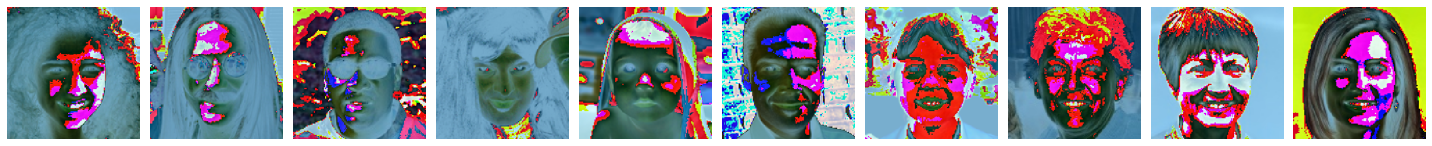

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
plotImages(imgs)
print(labels);

# Neural Net

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# if physical_devices:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
type(train_batches)

keras.preprocessing.image.DirectoryIterator

In [14]:
n_samples_train//n_batch

50

In [15]:
time_0 = time.time()

model.fit(x=train_batches, 
          validation_data=valid_batches, 
          epochs=10, 
          verbose=2, 
          steps_per_epoch=n_samples_train//n_batch, 
          validation_steps=n_samples_valid//n_batch)

print(f'Execution Time: {round((time.time() - time_0), 0)} seconds')

Epoch 1/10
50/50 - 23s - loss: 32.8228 - accuracy: 0.6020 - val_loss: 9.1212 - val_accuracy: 0.6100 - 23s/epoch - 459ms/step
Epoch 2/10
50/50 - 19s - loss: 4.5794 - accuracy: 0.7360 - val_loss: 3.0858 - val_accuracy: 0.7700 - 19s/epoch - 380ms/step
Epoch 3/10
50/50 - 19s - loss: 2.8927 - accuracy: 0.7640 - val_loss: 4.5669 - val_accuracy: 0.6700 - 19s/epoch - 375ms/step
Epoch 4/10
50/50 - 19s - loss: 1.8372 - accuracy: 0.8420 - val_loss: 4.1612 - val_accuracy: 0.6800 - 19s/epoch - 373ms/step
Epoch 5/10
50/50 - 20s - loss: 1.0869 - accuracy: 0.8620 - val_loss: 1.1655 - val_accuracy: 0.8200 - 20s/epoch - 402ms/step
Epoch 6/10
50/50 - 22s - loss: 0.3484 - accuracy: 0.9300 - val_loss: 2.2708 - val_accuracy: 0.8100 - 22s/epoch - 431ms/step
Epoch 7/10
50/50 - 19s - loss: 0.2581 - accuracy: 0.9560 - val_loss: 1.4769 - val_accuracy: 0.8200 - 19s/epoch - 388ms/step
Epoch 8/10
50/50 - 20s - loss: 0.2350 - accuracy: 0.9520 - val_loss: 1.9732 - val_accuracy: 0.7000 - 20s/epoch - 396ms/step
Epoch 9

In [21]:
model.history.history

{'loss': [32.82278823852539,
  4.5793962478637695,
  2.8926548957824707,
  1.8371660709381104,
  1.0869300365447998,
  0.34844771027565,
  0.25813713669776917,
  0.23502729833126068,
  0.13345462083816528,
  0.1255314201116562],
 'accuracy': [0.6019999980926514,
  0.7360000014305115,
  0.7639999985694885,
  0.8420000076293945,
  0.8619999885559082,
  0.9300000071525574,
  0.9559999704360962,
  0.9520000219345093,
  0.972000002861023,
  0.9660000205039978],
 'val_loss': [9.121186256408691,
  3.0857672691345215,
  4.5668559074401855,
  4.161175727844238,
  1.165490746498108,
  2.2707793712615967,
  1.4769434928894043,
  1.9732252359390259,
  1.304619550704956,
  1.4582061767578125],
 'val_accuracy': [0.6100000143051147,
  0.7699999809265137,
  0.6700000166893005,
  0.6800000071525574,
  0.8199999928474426,
  0.8100000023841858,
  0.8199999928474426,
  0.699999988079071,
  0.8299999833106995,
  0.8100000023841858]}

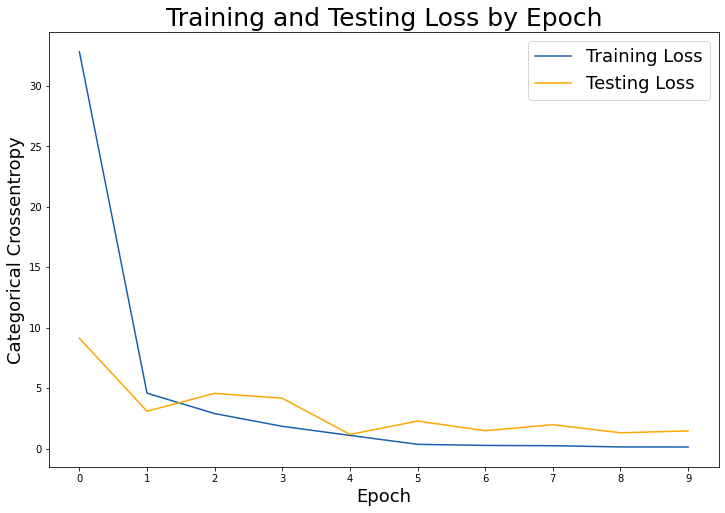

In [23]:
# plotting per https://git.generalassemb.ly/DSIR-0124/lesson-cnn/blob/master/starter-code-fast-cpu.ipynb

# Check out our train loss and test loss over epochs.
train_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']
epoch_labels = model.history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);